This notebook tries to extend the results from the adversarial spheres paper: https://arxiv.org/pdf/1801.02774.pdf

In particular, we try to generate random images from two classes,
where each class has a different image norm.
The question is: how robust are standard CNN models trained on this dataset?

### Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent

tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Data utils

[1 1 1 1 0 0 0 0 1 0]


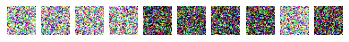

In [2]:
def generate_image_data(image_shape, m1, s1, m2, s2, num_samples):
    assert num_samples % 2 == 0
    
    xs = np.concatenate([
        np.random.normal(loc=m1, scale=s1, size=(num_samples // 2,) + image_shape),
        np.random.normal(loc=m2, scale=s2, size=(num_samples // 2,) + image_shape)
    ]).clip(0, 1)
    
    ys = np.concatenate([
        np.zeros(shape=num_samples // 2, dtype=np.int64),
        np.ones(shape=num_samples // 2, dtype=np.int64)
    ])
    
    perm = np.random.permutation(num_samples)
    xs = xs[perm]
    ys = ys[perm]
    
    return xs, ys

def plot_images(xs, flat=True, channels=1):
    for i, x in enumerate(xs):
        plt.subplot(1, len(xs), i + 1)
        plt.imshow(x)
        plt.axis("off")

x_tmp, y_tmp = generate_image_data(
    image_shape=(32, 32, 3),
    m1=0.1, s1=1,
    m2=0.9, s2=1,
    num_samples=10
)

print(y_tmp)
plot_images(x_tmp)

### Experiment setup

In [3]:
def run_experiment(
    image_shape,
    m1, s1,
    m2, s2,
    get_model,
    from_logits,
    train_epochs,
    attack_norm,
    attack_eps,
    attack_eps_step,
    attack_iters,
    train_batch_size=64,
    attack_batch_size=256,
    num_train=10 ** 4,
    num_test=2000,
    seed=42
):
    """
    Default values for num_train and num_test are size of CIFAR10 dataset.
    
    Keras code derived from https://keras.io/examples/vision/mnist_convnet/.
    
    ART code derived from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_retraining.ipynb
    and https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/238.
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    x_train, y_train = generate_image_data(
        image_shape=image_shape,
        m1=m1, s1=s1,
        m2=m2, s2=s2,
        num_samples=num_train,
    )

    x_test, y_test = generate_image_data(
        image_shape=image_shape,
        m1=m1, s1=s1,
        m2=m2, s2=s2,
        num_samples=num_test,
    )
    
    model = get_model(x_train[0].shape)
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
        optimizer="adam",
        metrics=["accuracy"]
    )
    model.fit(
        x_train,
        y_train,
        batch_size=train_batch_size,
        epochs=train_epochs,
        validation_data=(x_test, y_test),
        verbose=1,
    )
    model.trainable = False
    
    art_model = TensorFlowV2Classifier(
        model=model,
        input_shape=x_test[0].shape,
        nb_classes=2,
        loss_object=keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
        clip_values=[x_test.min(), x_test.max()],
    )
    art_attack = ProjectedGradientDescent(
        art_model,
        norm=attack_norm,
        eps=attack_eps,
        eps_step=attack_eps_step,
        max_iter=attack_iters,
        batch_size=attack_batch_size,
    )
    
    x_train_adv = art_attack.generate(x_train[:num_test], y=y_train[:num_test])    
    x_test_adv = art_attack.generate(x_test, y=y_test)
    
    _, nat_train_acc = model.evaluate(x_train, y_train, verbose=0)
    _, nat_test_acc = model.evaluate(x_test, y_test, verbose=0)
    _, adv_train_acc = model.evaluate(x_train_adv, y_train[:num_test], verbose=0)
    _, adv_test_acc = model.evaluate(x_test_adv, y_test, verbose=0)
    
    print("Nat train acc :", nat_train_acc)
    print("Nat test  acc :", nat_test_acc)
    print("Adv train acc :", adv_train_acc)
    print("Adv test  acc :", adv_test_acc)
    
    return dict(
        model=model,
        train_data=(x_train, y_train),
        test_data=(x_test, y_test),
        x_train_adv=x_train_adv,
        x_test_adv=x_test_adv,
    )

### Run experiments

In [4]:
%%time
res = run_experiment(
    image_shape=(32, 32, 3),
    m1=0.1, s1=1,
    m2=0.9, s2=1,
    get_model=lambda input_shape: keras.applications.DenseNet121(
        weights=None,
        input_shape=input_shape,
        classes=2,
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=2,
    attack_eps_step=0.2,
    attack_iters=20,
)

Epoch 1/5
157/157 [==============================] - 66s 245ms/step - loss: 0.0353 - accuracy: 0.9810 - val_loss: 0.8752 - val_accuracy: 0.5000
Epoch 2/5
157/157 [==============================] - 30s 189ms/step - loss: 6.0379e-06 - accuracy: 1.0000 - val_loss: 0.1118 - val_accuracy: 0.9960
Epoch 3/5
157/157 [==============================] - 30s 188ms/step - loss: 4.2145e-06 - accuracy: 1.0000 - val_loss: 9.8699e-06 - val_accuracy: 1.0000
Epoch 4/5
157/157 [==============================] - 30s 190ms/step - loss: 2.0176e-06 - accuracy: 1.0000 - val_loss: 3.5381e-07 - val_accuracy: 1.0000
Epoch 5/5
157/157 [==============================] - 29s 188ms/step - loss: 9.9874e-07 - accuracy: 1.0000 - val_loss: 2.4229e-07 - val_accuracy: 1.0000
Nat train acc : 1.0
Nat test  acc : 1.0
Adv train acc : 0.9745000004768372
Adv test  acc : 0.9710000157356262
Wall time: 5min 48s


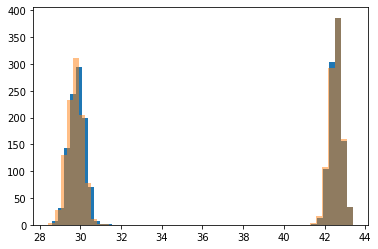

In [5]:
num_test = res["x_test_adv"].shape[0]
plt.hist(np.linalg.norm(res["test_data"][0].reshape((num_test, -1)), ord=2, axis=-1), bins=50);
plt.hist(np.linalg.norm(res["x_test_adv"].reshape((num_test, -1)), ord=2, axis=-1), bins=50, alpha=0.5);

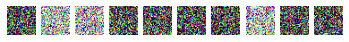

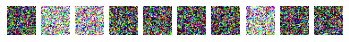

In [6]:
plot_images(res["test_data"][0][:10])
plt.show()
plot_images(res["x_test_adv"][:10])

---

In [7]:
%%time
res = run_experiment(
    image_shape=(32, 32, 3),
    m1=0.1, s1=1,
    m2=0.9, s2=1,
    get_model=lambda input_shape: keras.applications.DenseNet121(
        weights=None,
        input_shape=input_shape,
        classes=2,
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=4,
    attack_eps_step=0.1,
    attack_iters=40,
)

Epoch 1/5
157/157 [==============================] - 53s 216ms/step - loss: 0.0353 - accuracy: 0.9810 - val_loss: 0.7728 - val_accuracy: 0.5000
Epoch 2/5
157/157 [==============================] - 29s 186ms/step - loss: 5.7188e-06 - accuracy: 1.0000 - val_loss: 0.0906 - val_accuracy: 0.9990
Epoch 3/5
157/157 [==============================] - 29s 183ms/step - loss: 4.2498e-06 - accuracy: 1.0000 - val_loss: 1.2099e-05 - val_accuracy: 1.0000
Epoch 4/5
157/157 [==============================] - 30s 192ms/step - loss: 2.1501e-06 - accuracy: 1.0000 - val_loss: 4.3195e-07 - val_accuracy: 1.0000
Epoch 5/5
157/157 [==============================] - 31s 201ms/step - loss: 8.3146e-07 - accuracy: 1.0000 - val_loss: 1.6934e-07 - val_accuracy: 1.0000
Nat train acc : 1.0
Nat test  acc : 1.0
Adv train acc : 0.9595000147819519
Adv test  acc : 0.9595000147819519
Wall time: 7min 51s


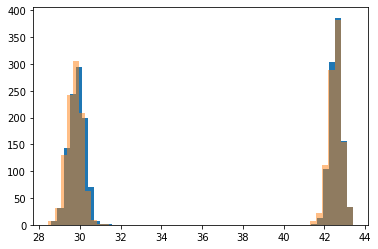

In [8]:
num_test = res["x_test_adv"].shape[0]
plt.hist(np.linalg.norm(res["test_data"][0].reshape((num_test, -1)), ord=2, axis=-1), bins=50);
plt.hist(np.linalg.norm(res["x_test_adv"].reshape((num_test, -1)), ord=2, axis=-1), bins=50, alpha=0.5);

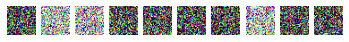

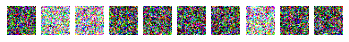

In [9]:
plot_images(res["test_data"][0][:10])
plt.show()
plot_images(res["x_test_adv"][:10])

---

In [10]:
%%time
res = run_experiment(
    image_shape=(32, 32, 3),
    m1=0.1, s1=1,
    m2=0.9, s2=1,
    get_model=lambda input_shape: keras.applications.DenseNet121(
        weights=None,
        input_shape=input_shape,
        classes=2,
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=8,
    attack_eps_step=0.8,
    attack_iters=20,
)

Epoch 1/5
157/157 [==============================] - 53s 215ms/step - loss: 0.0353 - accuracy: 0.9810 - val_loss: 0.8579 - val_accuracy: 0.5000
Epoch 2/5
157/157 [==============================] - 30s 191ms/step - loss: 5.8348e-06 - accuracy: 1.0000 - val_loss: 0.1469 - val_accuracy: 0.9835
Epoch 3/5
157/157 [==============================] - 30s 189ms/step - loss: 4.5037e-06 - accuracy: 1.0000 - val_loss: 1.2730e-05 - val_accuracy: 1.0000
Epoch 4/5
157/157 [==============================] - 30s 190ms/step - loss: 2.2035e-06 - accuracy: 1.0000 - val_loss: 3.6210e-07 - val_accuracy: 1.0000
Epoch 5/5
157/157 [==============================] - 30s 194ms/step - loss: 1.0381e-06 - accuracy: 1.0000 - val_loss: 2.2507e-07 - val_accuracy: 1.0000
Nat train acc : 1.0
Nat test  acc : 1.0
Adv train acc : 0.4934999942779541
Adv test  acc : 0.5074999928474426
Wall time: 5min 38s


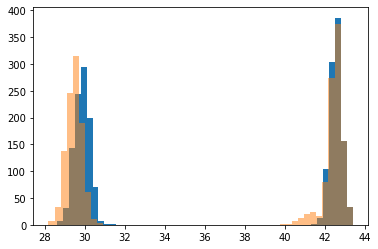

In [11]:
num_test = res["x_test_adv"].shape[0]
plt.hist(np.linalg.norm(res["test_data"][0].reshape((num_test, -1)), ord=2, axis=-1), bins=50);
plt.hist(np.linalg.norm(res["x_test_adv"].reshape((num_test, -1)), ord=2, axis=-1), bins=50, alpha=0.5);

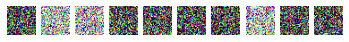

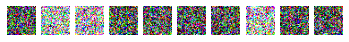

In [12]:
plot_images(res["test_data"][0][:10])
plt.show()
plot_images(res["x_test_adv"][:10])

---

In [13]:
%%time
res = run_experiment(
    image_shape=(32, 32, 3),
    m1=0.1, s1=1,
    m2=0.9, s2=1,
    get_model=lambda input_shape: keras.applications.DenseNet121(
        weights=None,
        input_shape=input_shape,
        classes=2,
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=16,
    attack_eps_step=0.8,
    attack_iters=40,
)

Epoch 1/5
157/157 [==============================] - 51s 209ms/step - loss: 0.0353 - accuracy: 0.9810 - val_loss: 0.7967 - val_accuracy: 0.5000
Epoch 2/5
157/157 [==============================] - 31s 197ms/step - loss: 5.0623e-06 - accuracy: 1.0000 - val_loss: 0.1141 - val_accuracy: 0.9970
Epoch 3/5
157/157 [==============================] - 30s 193ms/step - loss: 3.7719e-06 - accuracy: 1.0000 - val_loss: 1.0957e-05 - val_accuracy: 1.0000
Epoch 4/5
157/157 [==============================] - 30s 193ms/step - loss: 2.2479e-06 - accuracy: 1.0000 - val_loss: 3.7944e-07 - val_accuracy: 1.0000
Epoch 5/5
157/157 [==============================] - 30s 192ms/step - loss: 8.9161e-07 - accuracy: 1.0000 - val_loss: 2.0868e-07 - val_accuracy: 1.0000
Nat train acc : 1.0
Nat test  acc : 1.0
Adv train acc : 0.40799999237060547
Adv test  acc : 0.41200000047683716
Wall time: 7min 57s


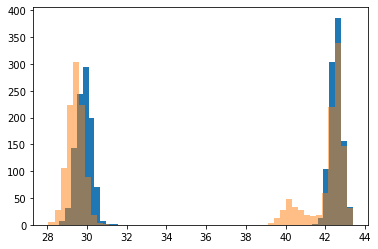

In [14]:
num_test = res["x_test_adv"].shape[0]
plt.hist(np.linalg.norm(res["test_data"][0].reshape((num_test, -1)), ord=2, axis=-1), bins=50);
plt.hist(np.linalg.norm(res["x_test_adv"].reshape((num_test, -1)), ord=2, axis=-1), bins=50, alpha=0.5);

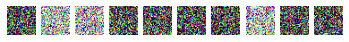

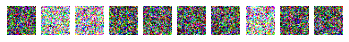

In [15]:
plot_images(res["test_data"][0][:10])
plt.show()
plot_images(res["x_test_adv"][:10])